In [1]:

from statistics import mean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
import glob
import datetime
import math 

from pandarallel import pandarallel
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold 
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from plotly.offline import iplot

import warnings 

warnings.filterwarnings("ignore")

from typing import List, Optional


# pd.set_option('max_columns', None)
# pd.set_option('max_rows', None)
# pd.options.display.float_format = "{:,.2f}".format


# DATASET

In [20]:
# import dataset

data = pd.read_csv("data1.csv")

In [21]:
data.head()

,Unnamed: 0,Date of Transfer,Postcode,Property Type,Old/New,Duration,House number,Flat number,Street name,Village,Town/City,District,County,PPDCategory Type,Record Status - monthly file only,Time Difference,Length Of Years,adjusted_price
0,336,23/02/2018 00:00,YO31 7PA,S,N,L,MONKBRIDGE COURT,FLAT 8,MONKGATE,NaN,YORK,YORK,YORK,B,A,1625 days 15:57:29.171653,5,194131
1,346,02/03/2018 00:00,YO61 3PH,D,N,F,OLD ORCHARDS,NaN,NEW INN LANE,EASINGWOLD,YORK,HAMBLETON,NORTH YORKSHIRE,B,A,1645 days 15:57:29.171653,5,274002
2,445,02/03/2018 00:00,YO10 3HB,S,N,F,11,NaN,GREEN DYKES LANE,NaN,YORK,YORK,YORK,B,A,1645 days 15:57:29.171653,5,303399
3,446,29/01/2018 00:00,YO24 1LQ,O,N,F,20 - 22,NaN,TADCASTER ROAD,DRINGHOUSES,YORK,YORK,YORK,B,A,1650 days 15:57:29.171653,5,1109320
4,447,14/03/2018 00:00,YO26 5EP,S,N,F,43,NaN,JUTE ROAD,NaN,YORK,YORK,YORK,B,A,1606 days 15:57:29.171653,5,179709


In [22]:
#drop columns with missing values 
df = data.drop(['Unnamed: 0'], axis=1, inplace=False)


In [23]:
def get_data_summary(df):
    summary = pd.concat([df.dtypes, df.nunique(), 
                        df.count(), df.isnull().sum()], 
                       keys = ["dtypes", "nunique", "count", "missing"], 
                       axis=1)
    return summary 

get_data_summary(df)

,dtypes,nunique,count,missing
Date of Transfer,object,1177,65014,0
Postcode,object,15812,64911,103
Property Type,object,5,65014,0
Old/New,object,2,65014,0
Duration,object,2,65014,0
House number,object,6053,65014,0
Flat number,object,826,4405,60609
Street name,object,8669,64084,930
Village,object,441,27272,37742
Town/City,object,10,65014,0


# FEATURES

FEATURE INFO

Transaction unique identifier A reference number which is generated automatically recording each published sale. The number is unique and will change each time a sale is recorded.

Price Sale price stated on the transfer deed.

Date of Transfer Date when the sale was completed, as stated on the transfer deed.

Property Type D = Detached, S = Semi-Detached, T = Terraced, F = Flats/Maisonettes, O = Other Note that: we only record the above categories to describe property type, we do not separately identify bungalows. end-of-terrace properties are included in the Terraced category above. ‘Other’ is only valid where the transaction relates to a property type that is not covered by existing values.

Old/New Indicates the age of the property and applies to all price paid transactions, residential and non-residential. Y = a newly built property, N = an established residential building

Duration Relates to the tenure: F = Freehold, L= Leasehold etc. Note that HM Land Registry does not record leases of 7 years or less in the Price Paid Dataset.

Town/City

District

County

PPD Category Type Indicates the type of Price Paid transaction. A = Standard Price Paid entry, includes single residential property sold for full market value. B = Additional Price Paid entry including transfers under a power of sale/repossessions, buy-to-lets (where they can be identified by a Mortgage) and transfers to non-private individuals. Note that category B does not separately identify the transaction types stated. HM Land Registry has been collecting information on Category A transactions from January 1995. Category B transactions were identified from October 2013.

Record Status - monthly file only Indicates additions, changes and deletions to the records.(see guide below). A = Addition C = Change D = Delete

## Adjust prices for inflation

In [24]:


#inflation values obtained from The UK Gov Website
inflation_values = (3.5, 0.99, 2.9, 9.24, 10.7)
mean_inflation = mean(inflation_values)
print(
    f"The mean inflation of house prices in the UK from 2018 - 2022 is {mean_inflation}%")


The mean inflation of house prices in the UK from 2018 - 2022 is 5.466%


In [25]:
## get time difference in years 

data = pd.to_datetime(df['Date of Transfer'])
df['Time Difference'] = pd.to_datetime("now") - data
df['Length Of Years'] = (df['Time Difference'].dt.days / 365).astype(int) + 1


In [26]:
# function that applies the inflation rate to price
#output = Adjusted price


# adjusted price = Price In Year + ((inflation rate/100) * Price in year)


def get_adjusted_price(

    base_price: float,
    inflation_rate: float,
    length_of_years: int


) -> float:

    inflation_ = inflation_rate / 100

    for i in range(length_of_years):
        inflation_value = inflation_ * base_price
        inflation_value += inflation_value

    adjusted_price = base_price + inflation_value

    return adjusted_price


In [27]:
df.head()

,Date of Transfer,Postcode,Property Type,Old/New,Duration,House number,Flat number,Street name,Village,Town/City,District,County,PPDCategory Type,Record Status - monthly file only,Time Difference,Length Of Years,adjusted_price
0,23/02/2018 00:00,YO31 7PA,S,N,L,MONKBRIDGE COURT,FLAT 8,MONKGATE,NaN,YORK,YORK,YORK,B,A,1626 days 07:56:23.665357,5,194131
1,02/03/2018 00:00,YO61 3PH,D,N,F,OLD ORCHARDS,NaN,NEW INN LANE,EASINGWOLD,YORK,HAMBLETON,NORTH YORKSHIRE,B,A,1646 days 07:56:23.665357,5,274002
2,02/03/2018 00:00,YO10 3HB,S,N,F,11,NaN,GREEN DYKES LANE,NaN,YORK,YORK,YORK,B,A,1646 days 07:56:23.665357,5,303399
3,29/01/2018 00:00,YO24 1LQ,O,N,F,20 - 22,NaN,TADCASTER ROAD,DRINGHOUSES,YORK,YORK,YORK,B,A,1651 days 07:56:23.665357,5,1109320
4,14/03/2018 00:00,YO26 5EP,S,N,F,43,NaN,JUTE ROAD,NaN,YORK,YORK,YORK,B,A,1607 days 07:56:23.665357,5,179709


In [10]:
# df["adjusted_price"] = df.apply(lambda x: get_adjusted_price(
#     x["Price"], mean_inflation, x['Length Of Years']), axis=1)


In [28]:
df['adjusted_price'] = df['adjusted_price'].astype(int)

In [12]:
# # drop Price column
# df.drop(columns = 'Price', axis = 1, inplace = True)

# EAST YORKSHIRE EDA

In [9]:
#create dataframe with East Yorkshire
df_yorkshire = df[df['County'] == 'EAST RIDING OF YORKSHIRE']

In [12]:
df.shape

(65014, 17)

In [14]:
# plot count function
# which towns/cities has the most houses in the East Yorkshire

def plot_count(col_list:List[str], 
              df:pd.DataFrame,
              hue:Optional[str]=None): 
    
    for col in col_list: 
        plt.figure(figsize=(20, 5))
        sns.countplot(x=col, data=df, 
                     hue = hue, order=df[col].value_counts().index)
        plt.title(f"{col} distribution")
        plt.show()

In [15]:
# analyse the top ten cities in East Yorkshire with the highest house sales
top_10 = df_yorkshire['Town/City'].value_counts()[:10].to_frame().reset_index()

In [16]:
top_10_cities = top_10['index'].tolist()

In [17]:
df_yorkshire_10 = df[df['Town/City'].isin(top_10_cities)]

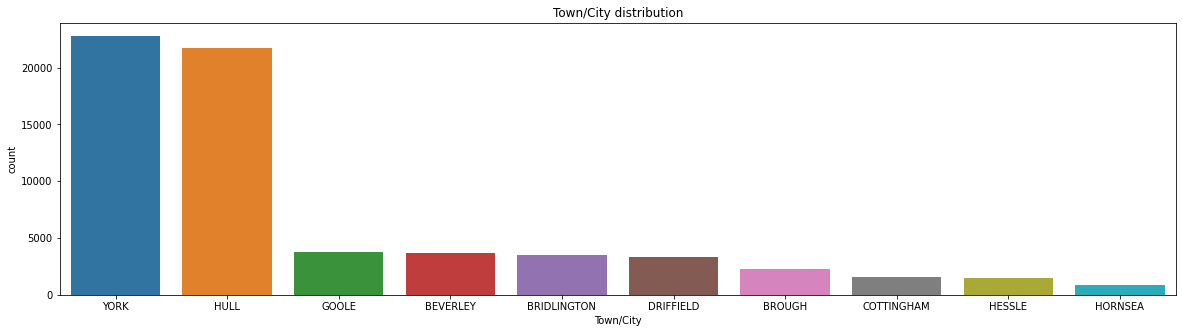

In [18]:
## plot showing the top 10 cities with largest house sales (from 2018) in East Yorkshire 

plot_count(col_list=['Town/City'], 
          df = df_yorkshire_10)

#merge hull and york for further analysis
# Two Reasons:

# They have the most houses sold
# Their distribution seems to be consistent with the experience across other top 10 cities with houses sold

In [19]:
#make a copy of dataframe to perform edits on
east_df = df_yorkshire_10.copy()

In [20]:
east_df.shape

(65014, 17)

In [21]:
east_df.head()

,Date of Transfer,Postcode,Property Type,Old/New,Duration,House number,Flat number,Street name,Village,Town/City,District,County,PPDCategory Type,Record Status - monthly file only,Time Difference,Length Of Years,adjusted_price
0,23/02/2018 00:00,YO31 7PA,S,N,L,MONKBRIDGE COURT,FLAT 8,MONKGATE,NaN,YORK,YORK,YORK,B,A,1626 days 07:28:51.231656,5,194131
1,02/03/2018 00:00,YO61 3PH,D,N,F,OLD ORCHARDS,NaN,NEW INN LANE,EASINGWOLD,YORK,HAMBLETON,NORTH YORKSHIRE,B,A,1646 days 07:28:51.231656,5,274002
2,02/03/2018 00:00,YO10 3HB,S,N,F,11,NaN,GREEN DYKES LANE,NaN,YORK,YORK,YORK,B,A,1646 days 07:28:51.231656,5,303399
3,29/01/2018 00:00,YO24 1LQ,O,N,F,20 - 22,NaN,TADCASTER ROAD,DRINGHOUSES,YORK,YORK,YORK,B,A,1651 days 07:28:51.231656,5,1109320
4,14/03/2018 00:00,YO26 5EP,S,N,F,43,NaN,JUTE ROAD,NaN,YORK,YORK,YORK,B,A,1607 days 07:28:51.231656,5,179709


<AxesSubplot:xlabel='adjusted_price', ylabel='Density'>

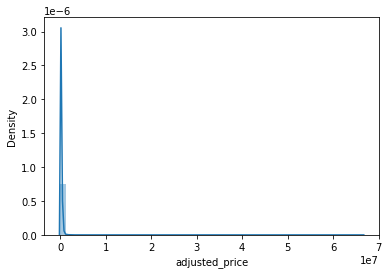

In [22]:
#plot density of prices

sns.distplot(east_df['adjusted_price'])

# Add datetime parameters to date of transfer column

In [23]:
east_df['Date of Transfer'] = pd.to_datetime(east_df['Date of Transfer'])

In [24]:
east_df = east_df.set_index('Date of Transfer')

In [25]:
east_df['Year'] = east_df.index.year
east_df['Month'] = east_df.index.month
east_df['Day'] = east_df.index.day

In [26]:
east_df.head()

,Postcode,Property Type,Old/New,Duration,House number,Flat number,Street name,Village,Town/City,District,County,PPDCategory Type,Record Status - monthly file only,Time Difference,Length Of Years,adjusted_price,Year,Month,Day
Date of Transfer,,,,,,,,,,,,,,,,,,,
2018-02-23,YO31 7PA,S,N,L,MONKBRIDGE COURT,FLAT 8,MONKGATE,NaN,YORK,YORK,YORK,B,A,1626 days 07:28:51.231656,5,194131,2018,2,23
2018-02-03,YO61 3PH,D,N,F,OLD ORCHARDS,NaN,NEW INN LANE,EASINGWOLD,YORK,HAMBLETON,NORTH YORKSHIRE,B,A,1646 days 07:28:51.231656,5,274002,2018,2,3
2018-02-03,YO10 3HB,S,N,F,11,NaN,GREEN DYKES LANE,NaN,YORK,YORK,YORK,B,A,1646 days 07:28:51.231656,5,303399,2018,2,3
2018-01-29,YO24 1LQ,O,N,F,20 - 22,NaN,TADCASTER ROAD,DRINGHOUSES,YORK,YORK,YORK,B,A,1651 days 07:28:51.231656,5,1109320,2018,1,29
2018-03-14,YO26 5EP,S,N,F,43,NaN,JUTE ROAD,NaN,YORK,YORK,YORK,B,A,1607 days 07:28:51.231656,5,179709,2018,3,14


In [27]:
# display the median price per year
east_df.groupby('Year')['adjusted_price'].median()

Year
2018    192467.0
2019    199677.0
2020    208552.0
2021    221864.0
2022    209661.0
Name: adjusted_price, dtype: float64

In [28]:
# create a new data set with the median price for each year for each property type
# note that as_index=false is needed when generating a table from a groupby command
year_type_data = east_df.groupby(['Property Type','Year'], as_index=False)['adjusted_price'].median()

# display the data set
year_type_data

,Property Type,Year,adjusted_price
0,D,2018,307836.0
1,D,2019,318929.0
2,D,2020,332796.0
3,D,2021,354982.0
4,D,2022,356091.5
5,F,2018,142547.0
6,F,2019,156414.0
7,F,2020,149758.0
8,F,2021,158632.0
9,F,2022,139774.0


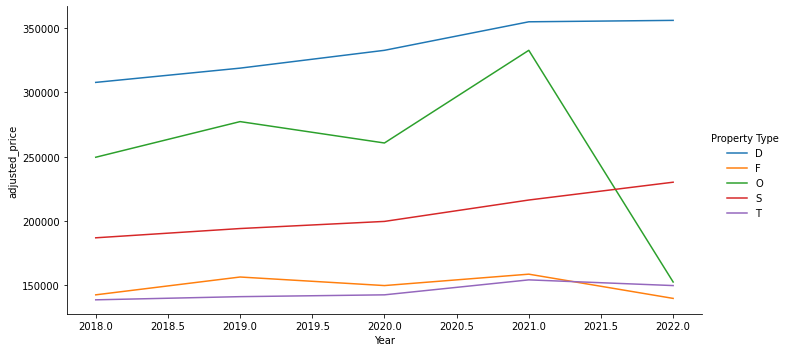

In [29]:
# plot lines showing the change in years with the property types
sns.relplot(kind='line', data=year_type_data, x='Year', y='adjusted_price', hue='Property Type', aspect=2);

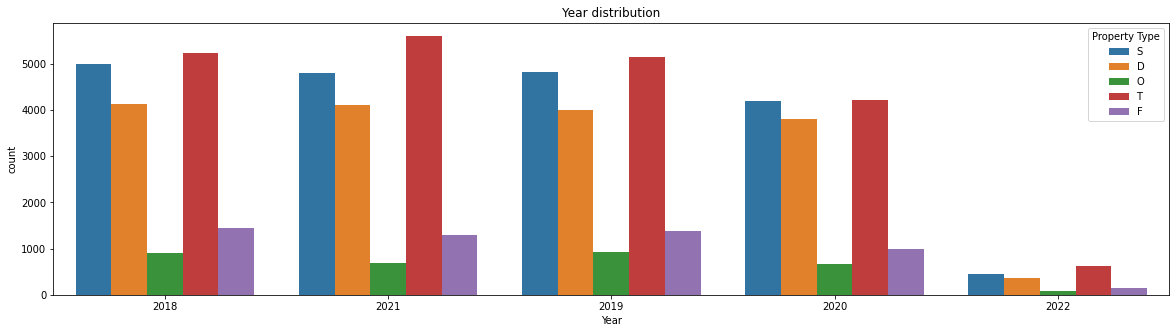

In [30]:
# filter by which of the houses are sold the most per year

plot_count(col_list=['Year'], 
          df = east_df, 
          hue='Property Type')

# most of the houses sold are semi-detached and Terraced houses and the distribution seems consistent across board 

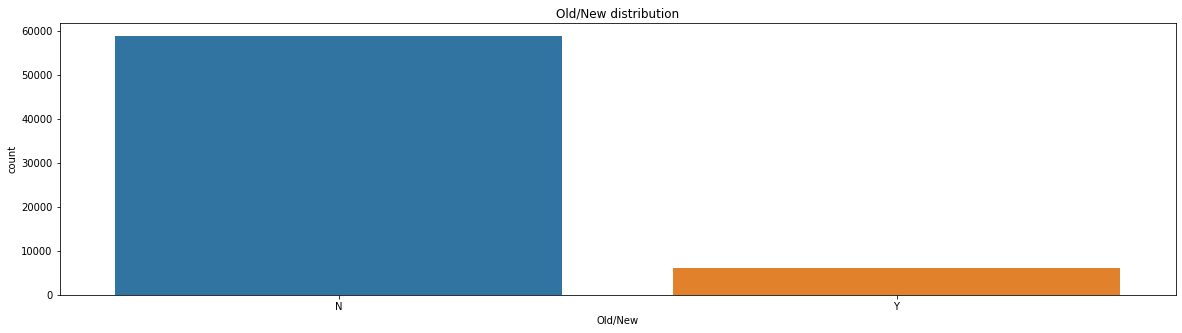

In [31]:
#Old/New age of the property, residential and non-residential. 
# Y = a newly built property, 
# N = an established residential building
# filter by which property age sold the most
plot_count(col_list=['Old/New'], 
          df = east_df, 
          )
# established buildings had the highest sales
# also indicates that low property development in East Yorkshire since 2018

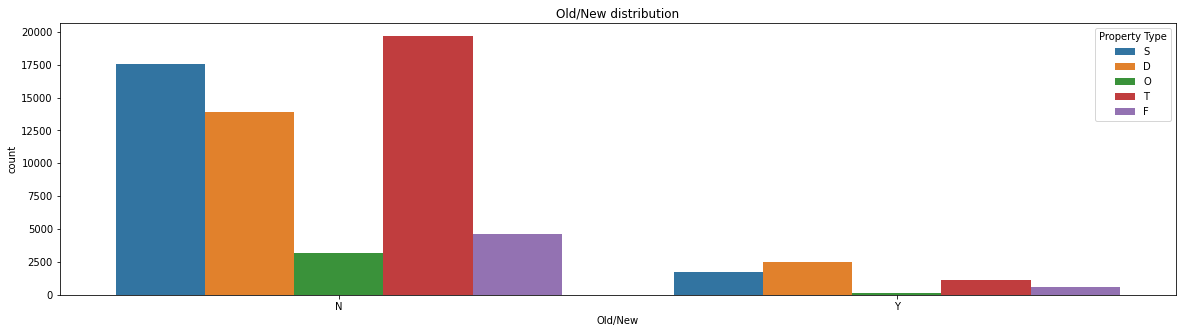

In [32]:
#Old/New age of the property, residential and non-residential. 
# Y = a newly built property, 
# N = an established residential building
# filter by which propertytype/age sold the most
 

plot_count(col_list=['Old/New'], 
          df = df_yorkshire_10,
          hue='Property Type')

#indicates terraced established residential buildings had the largest sales

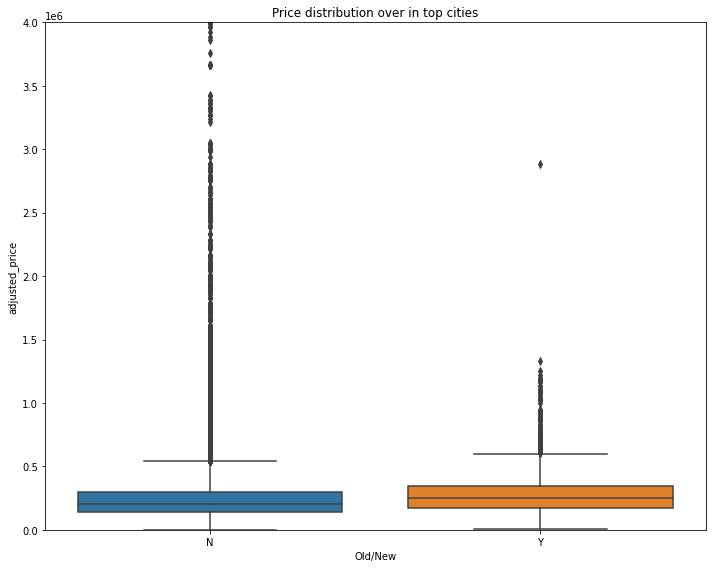

In [33]:
#Old/New age of the property, residential and non-residential. 
# Y = a newly built property, 
# N = an established residential building

# compare prices of newly built properties and established buildings

#lets represent this in a box plot 

figsize=(10, 8)


fig, ax = plt.subplots(figsize=figsize)
data:east_df   
ax = sns.boxplot(
    x = 'Old/New',
    y = 'adjusted_price',
    data = east_df, 
        
)
ax.set_ylim(0, 4000000)
ax.set_title('Price distribution over in top cities')
plt.style.use('bmh')
plt.tight_layout()

# median price of newly built properties is higher than established residential buildings 


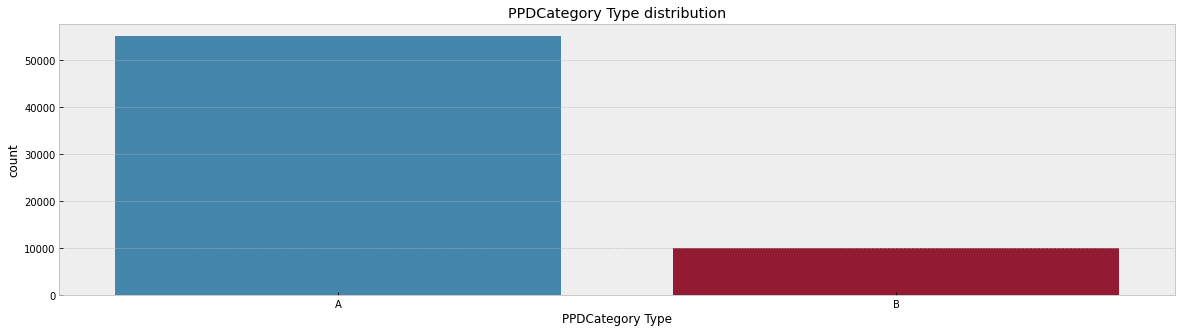

In [34]:
# PPD Category Type Indicates the type of Price Paid transaction.
# A = Standard Price Paid entry, includes single residential property sold for full market value.
# B = Additional Price Paid entry including transfers under a power of sale/repossessions, buy-to-lets (where they can be identified by a Mortgage) and transfers to non-private individuals
plot_count(col_list=['PPDCategory Type'], 
          df = east_df, 
          )
# plot indicates most houses sold were single residential properties

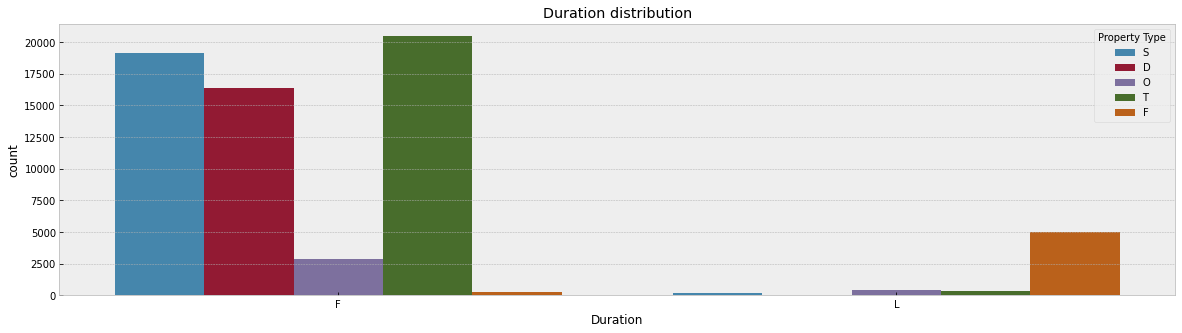

In [35]:
## plot showing the top 10 cities with largest house sales (from 2018) in East Yorkshire 
# Duration Relates to the tenure: F = Freehold, L= Leasehold etc. 
# Note that HM Land Registry does not record leases of 7 years or less in the Price Paid Dataset
plot_count(col_list=['Duration'], 
          df = east_df,
          hue='Property Type')

#buildings with flats are majorly on leasehold


In [36]:
east_df.head()

,Postcode,Property Type,Old/New,Duration,House number,Flat number,Street name,Village,Town/City,District,County,PPDCategory Type,Record Status - monthly file only,Time Difference,Length Of Years,adjusted_price,Year,Month,Day
Date of Transfer,,,,,,,,,,,,,,,,,,,
2018-02-23,YO31 7PA,S,N,L,MONKBRIDGE COURT,FLAT 8,MONKGATE,NaN,YORK,YORK,YORK,B,A,1626 days 07:28:51.231656,5,194131,2018,2,23
2018-02-03,YO61 3PH,D,N,F,OLD ORCHARDS,NaN,NEW INN LANE,EASINGWOLD,YORK,HAMBLETON,NORTH YORKSHIRE,B,A,1646 days 07:28:51.231656,5,274002,2018,2,3
2018-02-03,YO10 3HB,S,N,F,11,NaN,GREEN DYKES LANE,NaN,YORK,YORK,YORK,B,A,1646 days 07:28:51.231656,5,303399,2018,2,3
2018-01-29,YO24 1LQ,O,N,F,20 - 22,NaN,TADCASTER ROAD,DRINGHOUSES,YORK,YORK,YORK,B,A,1651 days 07:28:51.231656,5,1109320,2018,1,29
2018-03-14,YO26 5EP,S,N,F,43,NaN,JUTE ROAD,NaN,YORK,YORK,YORK,B,A,1607 days 07:28:51.231656,5,179709,2018,3,14


# Feature Engineering

In [13]:
#make a copy of the dataframe to perform edits on
# #east_df = df_yorkshire_10.copy()
# east_df = df[df['County'] == 'EAST RIDING OF YORKSHIRE']

In [29]:
df.head()

,Date of Transfer,Postcode,Property Type,Old/New,Duration,House number,Flat number,Street name,Village,Town/City,District,County,PPDCategory Type,Record Status - monthly file only,Time Difference,Length Of Years,adjusted_price
0,23/02/2018 00:00,YO31 7PA,S,N,L,MONKBRIDGE COURT,FLAT 8,MONKGATE,NaN,YORK,YORK,YORK,B,A,1626 days 07:56:23.665357,5,194131
1,02/03/2018 00:00,YO61 3PH,D,N,F,OLD ORCHARDS,NaN,NEW INN LANE,EASINGWOLD,YORK,HAMBLETON,NORTH YORKSHIRE,B,A,1646 days 07:56:23.665357,5,274002
2,02/03/2018 00:00,YO10 3HB,S,N,F,11,NaN,GREEN DYKES LANE,NaN,YORK,YORK,YORK,B,A,1646 days 07:56:23.665357,5,303399
3,29/01/2018 00:00,YO24 1LQ,O,N,F,20 - 22,NaN,TADCASTER ROAD,DRINGHOUSES,YORK,YORK,YORK,B,A,1651 days 07:56:23.665357,5,1109320
4,14/03/2018 00:00,YO26 5EP,S,N,F,43,NaN,JUTE ROAD,NaN,YORK,YORK,YORK,B,A,1607 days 07:56:23.665357,5,179709


In [31]:
cols_to_drop = ['County', 'Date of Transfer', 'Time Difference','Village', 'Flat number', 'District']
df.drop(columns=cols_to_drop, inplace=True)

In [32]:
df.head()

,Postcode,Property Type,Old/New,Duration,House number,Street name,Town/City,PPDCategory Type,Record Status - monthly file only,Length Of Years,adjusted_price
0,YO31 7PA,S,N,L,MONKBRIDGE COURT,MONKGATE,YORK,B,A,5,194131
1,YO61 3PH,D,N,F,OLD ORCHARDS,NEW INN LANE,YORK,B,A,5,274002
2,YO10 3HB,S,N,F,11,GREEN DYKES LANE,YORK,B,A,5,303399
3,YO24 1LQ,O,N,F,20 - 22,TADCASTER ROAD,YORK,B,A,5,1109320
4,YO26 5EP,S,N,F,43,JUTE ROAD,YORK,B,A,5,179709


In [17]:
df['adjusted_price'].describe()

count    6.501400e+04
mean     2.661480e+05
std      5.822598e+05
min      1.100000e+02
25%      1.386650e+05
50%      2.052240e+05
75%      3.050630e+05
max      6.655920e+07
Name: adjusted_price, dtype: float64

In [33]:
get_data_summary(df)

,dtypes,nunique,count,missing
Postcode,object,15812,64911,103
Property Type,object,5,65014,0
Old/New,object,2,65014,0
Duration,object,2,65014,0
House number,object,6053,65014,0
Street name,object,8669,64084,930
Town/City,object,10,65014,0
PPDCategory Type,object,2,65014,0
Record Status - monthly file only,object,1,65014,0
Length Of Years,int64,5,65014,0


<AxesSubplot:xlabel='Property Type'>

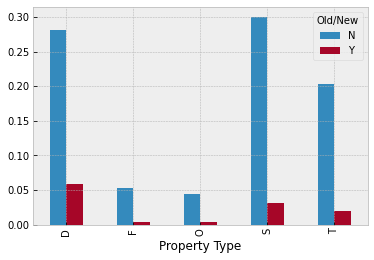

In [41]:
pd.crosstab(east_df['Property Type'], east_df['Old/New'],
            normalize=True).plot(kind='bar')

In [42]:
east_df['Property Type'].value_counts()

D    9688
S    9406
T    6336
F    1632
O    1389
Name: Property Type, dtype: int64

In [43]:
condlist = [ (east_df['Property Type'] == 'D') & (east_df['Old/New'] == 'Y'),
             (east_df['Property Type'] == 'D') & (east_df['Old/New'] == 'N'), 
             (east_df['Property Type'] == 'T') & (east_df['Old/New'] == 'Y'),
             (east_df['Property Type'] == 'T') & (east_df['Old/New'] == 'N'), 
             (east_df['Property Type'] == 'S') & (east_df['Old/New'] == 'Y'),
             (east_df['Property Type'] == 'S') & (east_df['Old/New'] == 'N'),
             (east_df['Property Type'] == 'F') & (east_df['Old/New'] == 'Y'),
             (east_df['Property Type'] == 'F') & (east_df['Old/New'] == 'N')]

choicelist = [ 'Newly built', 'Established', 'Newly built', 'Established', 'Newly built', 'Established', 'Newly built', 'Established']

east_df['Property_Age'] = np.select(condlist, choicelist, default='Other')


In [44]:
east_df['PPDCategory Type'].value_counts()

A    24791
B     3660
Name: PPDCategory Type, dtype: int64

In [45]:
pd.crosstab(east_df['PPDCategory Type'], east_df['Old/New'])

Old/New,N,Y
PPDCategory Type,,
A,22095,2696
B,3021,639


In [46]:
condlist = [ (east_df['PPDCategory Type'] == 'A') & (east_df['Old/New'] == 'Y'),
                (east_df['PPDCategory Type'] == 'A') & (east_df['Old/New'] == 'N'),
                (east_df['PPDCategory Type'] == 'B') & (east_df['Old/New'] == 'Y'),
                (east_df['PPDCategory Type'] == 'B') & (east_df['Old/New'] == 'N')]

choicelist = [ 'Standard_Old', 'Standard_New', 'Addtional_Old', 'Additional_New']

east_df['PPDCategory_Age'] = np.select(condlist, choicelist, default='Other')

In [47]:
comp_df = pd.crosstab(east_df['Town/City'], east_df['Old/New']).unstack().transpose().to_frame().reset_index()
comp_df.columns

Index(['Old/New', 'Town/City', 0], dtype='object')

In [34]:
## run encoding for the features 

# encode the features

from sklearn.preprocessing import LabelEncoder

for feature in df.columns:
    if df[feature].dtype == object:
        le = LabelEncoder()
        df[feature] = le.fit_transform(df[feature])

In [35]:
df

,Postcode,Property Type,Old/New,Duration,House number,Street name,Town/City,PPDCategory Type,Record Status - monthly file only,Length Of Years,adjusted_price
0,13096,3,0,1,3850,5092,9,1,0,5,194131
1,15427,0,0,0,4104,5278,9,1,0,5,274002
2,8607,3,0,0,82,3131,9,1,0,5,303399
3,10509,2,0,0,313,7419,9,1,0,5,1109320
4,11925,3,0,0,711,3976,9,1,0,5,179709
...,...,...,...,...,...,...,...,...,...,...,...
65009,2755,3,0,0,1169,620,2,0,0,1,260690
65010,7441,4,0,0,333,4378,8,0,0,1,149758
65011,1538,3,0,0,901,6109,8,0,0,1,291196
65012,4764,4,0,0,357,3522,8,0,0,1,82089


## Run Training 

In [36]:
from train import call_model
model_list = ['linear', 'random_forest', 'gradient_boost', 
            'extra_trees', 'ada_boost', 'decision_tree', 'xgboost']
label = 'adjusted_price'   


metrics_ = call_model(model_list, label, df)

In [37]:
metrics_

,test_r2,test_mse,test_mae,test_evs,test_rmsle
linear,0.033174,4.771893e+11,127433.109919,0.033389,690788.869970
random_forest,0.063231,4.623542e+11,90750.830679,0.063272,679966.288662
gradient_boost,0.007519,4.898512e+11,105365.822466,0.007670,699893.727186
extra_trees,0.016259,4.855374e+11,97627.439023,0.016266,696805.156232
ada_boost,-0.906642,9.410467e+11,300795.514359,-0.819407,970075.623328
decision_tree,-0.280253,6.318848e+11,110103.567951,-0.280238,794911.815020
xgboost,0.043036,4.723217e+11,97264.274033,0.043210,687256.634774


In [38]:
from train_lightgbm import train_regressor_model


In [39]:
model = train_regressor_model(df, label)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
LightGBM rmse on eval set: 156446251104.7374
LightGBM r2 on eval set: 0.1908
